In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
%matplotlib inline
#plt.style.use('ggplot')

import seaborn as sns
sns.set()
import talib as ta

from scipy.stats import randint
import pickle

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, auc, mean_squared_error, confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC, LinearSVC


def roc_plot(estimator, auc_cv=False, title="ROC Curve"):
    y_pred = estimator.predict(X_test)
    y_pred_prob = estimator.predict_proba(X_test)[:,1]
    #y_pred_prob = y_pred
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    print('Model Score: {}'.format(estimator.score(X_test, y_test)))
    print("Accuracy Score: {}".format(accuracy_score(y_test, y_pred)))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.show()

    #If the AUC is greater than 0.5, the model is better than random guessing. Always a good sign!
    print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
    
    if (auc_cv):
        cv_auc = cross_val_score(estimator, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
        print("AUC scores computed using 5-fold cross-validation: {}".format(np.mean(cv_auc)))
    
def ridge_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

def get_small_coef(coef_):
    remove_list = []
    for i, val in zip(df.columns, np.transpose(coef_)):
        tmp = str(val)[1]
        #print(i, val)
        if tmp == '0':
            remove_list.append(i)
    return remove_list

def set_new_Xy(remove_cols):
    global X, X_train, X_test, X_valid, X_final
    #print(X.shape)
    
    X = df.drop(remove_cols, axis=1).values
    #print(X.shape)
    X_train = X[:split]
    X_rest = X[split:]

    X_test = X_rest[:half_split]
    X_final = X_rest[half_split:]
    
def return_plot(estimator, plot=False):
    df['Predicted_Signal'] = estimator.predict(X)
    Cumulative_returns = np.cumsum(df[split:]['Returns'])
    df['Startegy_returns'] = df['Returns']* df['Predicted_Signal'].shift(1)
    Cumulative_Strategy_returns = np.cumsum(df[split:]['Startegy_returns'])
    print('Return: {}%'.format(Cumulative_Strategy_returns[-1]))
    
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(Cumulative_returns, color='r',label = 'Returns')
        plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
        plt.legend()
        plt.show()

path = '/Users/ballmdr/data'
filename = 'EURUSD_D1.csv'
df = pd.read_csv(path + '/' + filename, names=['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
df['Datetime'] = pd.to_datetime(df.Date + ' ' + df.Time)
df = df.drop(['Date', 'Time'], axis=1)
df = df.set_index('Datetime')
df['Target'] = np.where(df.Close.shift(-1) > df.Close, 1, -1)

df['trendline'] = ta.HT_TRENDLINE(df.Close)
df['kama'] = ta.KAMA(df.Close, timeperiod=35)
df['midpoint'] = ta.MIDPRICE(df.High, df.Low, timeperiod=14)
df['sar'] = ta.SAR(df.High, df.Low, acceleration=0, maximum=0)
df['wma'] = ta.WMA(df.Close, timeperiod=35)
df['upperband'], df['middleband'], df['lowerband'] = ta.BBANDS(df.Close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df['Returns'] = df.Close.pct_change()
df['ATR'] = ta.ATR(df.High, df.Low, df.Close, timeperiod=14)
df['ATR_diff'] = df.ATR - df.ATR.shift(1)
df['aroondown'], df['aroonup'] = ta.AROON(df.High, df.Low, timeperiod=14)
df['cci'] = ta.CCI(df.High, df.Low, df.Close, timeperiod=14)
df['macd'], df['macdsignal'], df['macdhist'] = ta.MACD(df.Close, fastperiod=12, slowperiod=26, signalperiod=9)
df['mfi'] = ta.MFI(df.High, df.Low, df.Close, df.Volume, timeperiod=14)
df['mom'] = ta.MOM(df.Close, timeperiod=14)
df['willr'] = ta.WILLR(df.High, df.Low, df.Close, timeperiod=14)
df['EMA5'] = np.log(df.Close.rolling(5).mean())
df['EMA8'] = np.log(df.Close.rolling(8).mean())
df['5_8'] = np.where(df.EMA5 > df.EMA8, 1, -1)
df['MA35'] = df.Close.rolling(35).mean()
df['MA200'] = df.Close.rolling(200).mean()
df['35_200'] = np.where(df.MA35 > df.MA200, 1, -1)
df['Candle_body'] = df.Open - df.Close
df['High_low'] = df.High - df.Low
df['ADX'] = ta.ADX(df.High, df.Low, df.Close, timeperiod=14)
df['ADX_diff'] = df.ADX - df.ADX.shift(1)
df['ROC'] = ta.ROC(df.Close, timeperiod=10)
df['ROC_diff'] = df.ROC - df.ROC.shift(1)
df['RSI'] = ta.RSI(df.Close, timeperiod=14)
df['RSI_diff'] = df.RSI - df.RSI.shift(1)
df['obv'] = ta.OBV(df.Close, df.Volume)
df['trendmode'] = ta.HT_TRENDMODE(df.Close)
df['sine'], df['leadsine'] = ta.HT_SINE(df.Close)
df['avgprice'] = ta.AVGPRICE(df.Open, df.High, df.Low, df.Close)
df['typical_price'] = ta.TYPPRICE(df.High, df.Low, df.Close)
df['weight_close'] = ta.WCLPRICE(df.High, df.Low, df.Close)

df['Three_black_crows'] = ta.CDL3BLACKCROWS(df.Open, df.High, df.Low, df.Close)
df['Three_white_soldiers'] = ta.CDL3WHITESOLDIERS(df.Open, df.High, df.Low, df.Close)
df['Harami'] = ta.CDLHARAMI(df.Open, df.High, df.Low, df.Close)
df['Belt'] = ta.CDLBELTHOLD(df.Open, df.High, df.Low, df.Close)
df['Dark_cloud'] = ta.CDLDARKCLOUDCOVER(df.Open, df.High, df.Low, df.Close, penetration=0)
df['Doji'] = ta.CDLDOJI(df.Open, df.High, df.Low, df.Close)
df['Doji_star'] = ta.CDLDOJISTAR(df.Open, df.High, df.Low, df.Close)
df['Dragonfly'] = ta.CDLDRAGONFLYDOJI(df.Open, df.High, df.Low, df.Close)
df['Engulfing'] = ta.CDLENGULFING(df.Open, df.High, df.Low, df.Close)
df['Evening_star'] = ta.CDLEVENINGSTAR(df.Open, df.High, df.Low, df.Close)
df['Hammer'] = ta.CDLHAMMER(df.Open, df.High, df.Low, df.Close)
df['Hanging_man'] = ta.CDLHANGINGMAN(df.Open, df.High, df.Low, df.Close)
df['Highwave'] = ta.CDLHIGHWAVE(df.Open, df.High, df.Low, df.Close)
df['Median'] = ta.MEDPRICE(df.High, df.Low)
df['Median_diff'] = df.Median - df.Median.shift(1)
df['STD'] = np.std(df.Close)
df['STD_diff'] = df.STD - df.STD.shift(1)
df['Pearson_coef'] = ta.CORREL(df.High, df.Low, timeperiod=30)
df['Beta'] = ta.BETA(df.High, df.Low, timeperiod=5)
df['Linear_regression'] = ta.LINEARREG(df.Close, timeperiod=14)
df['Linear_regression_diff'] = df.Linear_regression - df.Linear_regression.shift(1)
df['Linear_angle'] = ta.LINEARREG_ANGLE(df.Close, timeperiod=14)
df['Linear_angle_diff'] = df.Linear_angle - df.Linear_angle.shift(1)
df['Linear_slope'] = ta.LINEARREG_SLOPE(df.Close, timeperiod=14)
df['Linear_slope_diff'] = df.Linear_slope - df.Linear_slope.shift(1)
df['Linear_intercept'] = ta.LINEARREG_INTERCEPT(df.Close, timeperiod=14)
df['Linear_intercept_diff'] = df.Linear_intercept - df.Linear_intercept.shift(1)

print(df.iloc[:15])
print('Shape before: {}'.format(df.shape))
df = df.dropna()
print('Shape after: {}'.format(df.shape))

df.to_csv('data_max.csv')

drop_cols = ['Target']
X = df.drop(drop_cols, axis=1).values
#X = df[['Linear_slope', 'Linear_slope_diff']].values
y = df.Target.values

df = df.drop('Target', axis=1)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=421)

split = int(len(df) * 0.60)
X_train = X[:split]
X_rest = X[split:]
y_train = y[:split]
y_rest = y[split:]

half_split = int(len(X_rest) * 0.50)
X_test = X_rest[:half_split]
X_final = X_rest[half_split:]
y_test = y_rest[:half_split]
y_final = y_rest[half_split:]
print(X.shape)

               Open     High      Low    Close   Volume  Target  trendline  \
Datetime                                                                     
2003-08-04  1.12672  1.13734  1.12564  1.13523  1269388       1        NaN   
2003-08-05  1.13518  1.13969  1.13054  1.13908  1283508      -1        NaN   
2003-08-06  1.13868  1.14250  1.13238  1.13364  1267372       1        NaN   
2003-08-07  1.13375  1.14138  1.13173  1.13640  1272324      -1        NaN   
2003-08-08  1.13632  1.13774  1.12861  1.13053  1179168       1        NaN   
2003-08-11  1.12882  1.13788  1.12615  1.13544  1332392      -1        NaN   
2003-08-12  1.13535  1.13709  1.12659  1.12727  1340768       1        NaN   
2003-08-13  1.12724  1.13302  1.12169  1.13093  1352592      -1        NaN   
2003-08-14  1.13097  1.13365  1.12234  1.12650  1336036      -1        NaN   
2003-08-15  1.12629  1.12868  1.12396  1.12633  1208012      -1        NaN   
2003-08-17  1.12420  1.12675  1.12337  1.12614    68012      -1 

# Find Coef of Features

In [54]:
#use Regression Filter
print('Shape before: {}'.format(X.shape))
log = LogisticRegression().fit(X_train, y_train)
coef_remove_list = get_small_coef(log.coef_)
print(coef_remove_list)
set_new_Xy(coef_remove_list)
print('Shape after: {}'.format(X.shape))

Shape before: (4655, 70)
[]
Shape after: (4655, 70)


/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [93]:
#use Linear SVM
print('Shape before: {}'.format(X.shape))
log = LinearSVC().fit(X_train, y_train)
coef_remove_list = get_small_coef(log.coef_)
print(coef_remove_list)
#set_new_Xy(coef_remove_list)
#print('Shape after: {}'.format(X.shape))

Shape before: (4655, 70)
[]


/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Ada Boosting

train score: 0.6874328678839957
Model Score: 0.5026852846401718
Accuracy Score: 0.5026852846401718
[[152 321]
 [142 316]]
              precision    recall  f1-score   support

          -1       0.52      0.32      0.40       473
           1       0.50      0.69      0.58       458

   micro avg       0.50      0.50      0.50       931
   macro avg       0.51      0.51      0.49       931
weighted avg       0.51      0.50      0.49       931



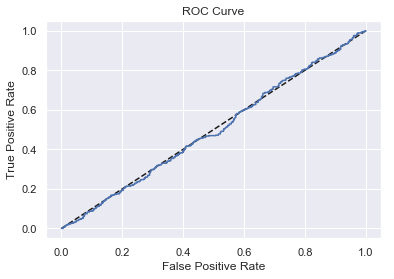

AUC: 0.49565626817581726
Return: 0.12424578316570312%


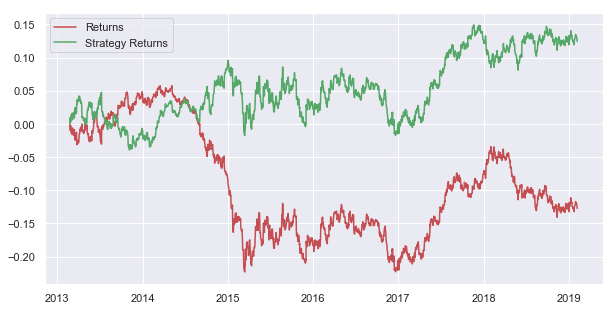

train score: 0.5055495882563552
Model Score: 0.49194414607948445
Accuracy Score: 0.49194414607948445
[[  0 473]
 [  0 458]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       473
           1       0.49      1.00      0.66       458

   micro avg       0.49      0.49      0.49       931
   macro avg       0.25      0.50      0.33       931
weighted avg       0.24      0.49      0.32       931



/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


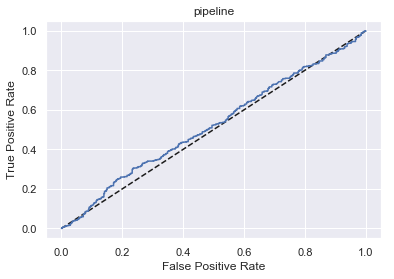

AUC: 0.520442312841013
Return: -0.12755405298553968%


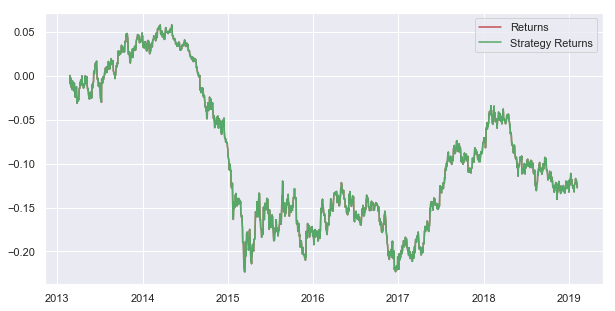

In [57]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=0.5
)
steps = [
    ('scaler', StandardScaler()),
    ('ada', ada_clf)
]
pipeline = Pipeline(steps).fit(X_train, y_train)
ada_clf.fit(X_train, y_train)
print('train score: {}'.format(ada_clf.score(X_train, y_train)))
roc_plot(ada_clf)
return_plot(ada_clf)

print('train score: {}'.format(pipeline.score(X_train, y_train)))
roc_plot(pipeline, title="pipeline")
return_plot(pipeline)

# Logistic Regression

/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model Score: 0.48764769065520946
Accuracy Score: 0.48764769065520946
[[166 307]
 [170 288]]
              precision    recall  f1-score   support

          -1       0.49      0.35      0.41       473
           1       0.48      0.63      0.55       458

   micro avg       0.49      0.49      0.49       931
   macro avg       0.49      0.49      0.48       931
weighted avg       0.49      0.49      0.48       931



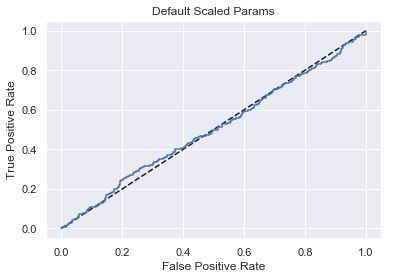

AUC: 0.5018741287147908
AUC scores computed using 5-fold cross-validation: 0.5231544579897308
Return: -0.019699686322442567%


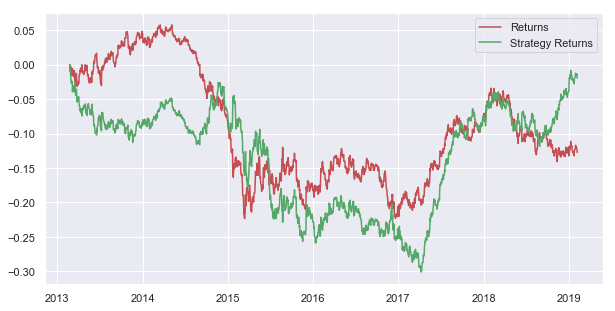

In [58]:
#default scaler
#scaler better!
steps = [
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression())
]
log_reg_scaled = Pipeline(steps).fit(X_train, y_train)
roc_plot(log_reg_scaled, auc_cv=True, title='Default Scaled Params')
return_plot(log_reg_scaled)

Best Params: {'log_reg__C': 0.08858667904100823, 'log_reg__penalty': 'l1'}
Best Score: 0.5102040816326531
Model Score: 0.523093447905478
Accuracy Score: 0.523093447905478
[[244 229]
 [215 243]]
              precision    recall  f1-score   support

          -1       0.53      0.52      0.52       473
           1       0.51      0.53      0.52       458

   micro avg       0.52      0.52      0.52       931
   macro avg       0.52      0.52      0.52       931
weighted avg       0.52      0.52      0.52       931



/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


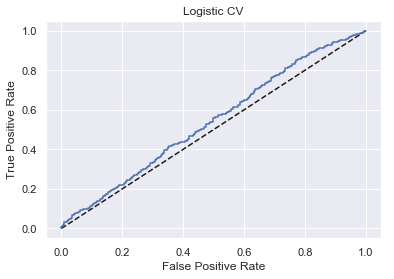

AUC: 0.5412169834836636
Return: -0.12560755768990384%


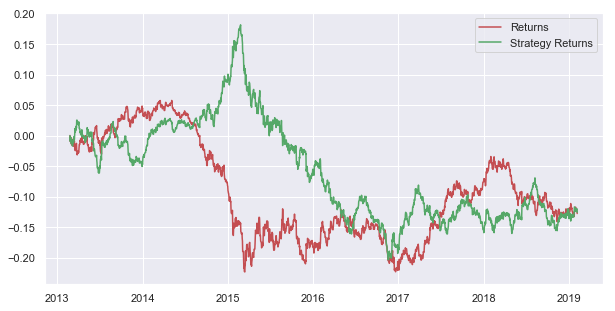

In [17]:
#CV
steps = [
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression())
]
pipeline = Pipeline(steps)
params = {
    'log_reg__penalty': ['l1', 'l2'],
    'log_reg__C': np.logspace(-4, 4, 20)
}
log_reg_cv = GridSearchCV(pipeline, params, cv=5, n_jobs=-1)
log_reg_cv.fit(X_train, y_train)
print('Best Params: {}'.format(log_reg_cv.best_params_))
print('Best Score: {}'.format(log_reg_cv.best_score_))
roc_plot(log_reg_cv, auc_cv=False, title='Logistic CV')
return_plot(log_reg_cv)

Model Score: 0.5080558539205156
Accuracy Score: 0.5080558539205156
[[473   0]
 [458   0]]
              precision    recall  f1-score   support

          -1       0.51      1.00      0.67       473
           1       0.00      0.00      0.00       458

   micro avg       0.51      0.51      0.51       931
   macro avg       0.25      0.50      0.34       931
weighted avg       0.26      0.51      0.34       931



/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


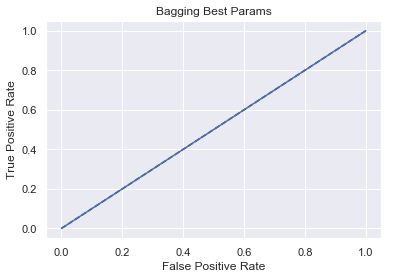

AUC: 0.5
Return: 0.12755405298553968%


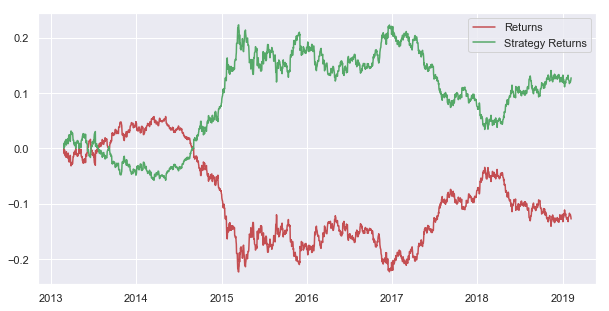

In [18]:
#bagging from Best Params
log_reg_bag_params = BaggingClassifier(
    LogisticRegression(C=log_reg_cv.best_params_['log_reg__C'],penalty=log_reg_cv.best_params_['log_reg__penalty']),
    n_estimators=1000,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1
)
log_reg_bag_params.fit(X_train, y_train)
roc_plot(log_reg_bag_params, auc_cv=False, title='Bagging Best Params')
return_plot(log_reg_bag_params)

Model Score: 0.5080558539205156
Accuracy Score: 0.5080558539205156
[[473   0]
 [458   0]]
              precision    recall  f1-score   support

          -1       0.51      1.00      0.67       473
           1       0.00      0.00      0.00       458

   micro avg       0.51      0.51      0.51       931
   macro avg       0.25      0.50      0.34       931
weighted avg       0.26      0.51      0.34       931



/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


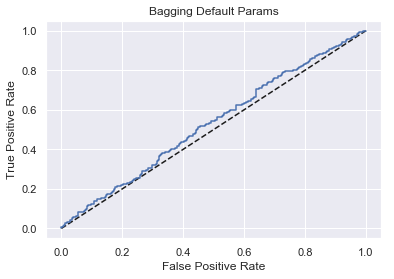

AUC: 0.5300276041618582
Return: 0.12755405298553968%


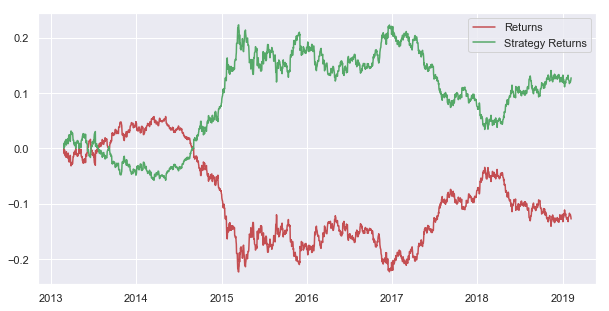

In [19]:
#bagging default
log_reg_bag = BaggingClassifier(
    LogisticRegression(),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1
)
log_reg_bag.fit(X_train, y_train)
roc_plot(log_reg_bag, auc_cv=False, title='Bagging Default Params')
return_plot(log_reg_bag)

In [74]:
pickle.dump(log_reg_cv, open('log_reg_final.pickle', 'wb'))

In [20]:
# test on final data
model = pickle.load(open('log_reg_final.pickle', 'rb'))
y_pred = model.predict(X_final)
print(accuracy_score(y_final, y_pred))
print(classification_report(y_final, y_pred))

ValueError: operands could not be broadcast together with shapes (931,2) (73,) (931,2) 

# Ensemble Final Model

In [4]:
log_clf = pickle.load(open('log_reg_final.pickle', 'rb'))
knn_clf = pickle.load(open('knn_final.pickle', 'rb'))

voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_clf),
        ('knn', knn_clf)
    ],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

for clf in (log_clf, knn_clf, voting_clf):
    #clf.fit(X_train, y_train)
    #roc_plot(clf)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

#roc_plot(voting_clf)
return_plot(voting_clf)

/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: operands could not be broadcast together with shapes (931,70) (73,) (931,70) 

In [78]:
pickle.dump(voting_clf, open('voting.pickle', 'wb'))

In [86]:
model = pickle.load(open('voting.pickle', 'rb'))
y_pred = model.predict(X_final)
print(accuracy_score(y_final, y_pred))
print(classification_report(y_final, y_pred))
model.predict(X_final[40:41,:])

0.520509977827051
              precision    recall  f1-score   support

          -1       0.52      0.75      0.61       918
           1       0.52      0.28      0.37       886

   micro avg       0.52      0.52      0.52      1804
   macro avg       0.52      0.52      0.49      1804
weighted avg       0.52      0.52      0.49      1804



array([-1])

In [85]:
X_final[40:41,:].shape

(1, 73)

In [27]:
log_clf = LogisticRegression()
dec_clf = DecisionTreeClassifier()
rnd_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_clf),
        ('dc', dec_clf),
        ('rf', rnd_clf),
        ('knn', knn_clf),
        ('svm', svm_clf)
    ],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, dec_clf, knn_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    #roc_plot(clf)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda2/env

LogisticRegression 0.5301724137931034
RandomForestClassifier 0.4956896551724138
DecisionTreeClassifier 0.4870689655172414
KNeighborsClassifier 0.5129310344827587


/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC 0.46551724137931033


/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier 0.5043103448275862


# SVM

In [25]:
# Polynomial
polynomial_svm_clf = Pipeline([
    ('poly_features', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('svm_clf', SVC())
])
params = {
    'poly_features__degree': np.arange(1,5),
    'svm_clf__C': np.arange(1,10),
    'svm_clf__kernel': ['poly'],
    'svm_clf__gamma': ['auto'],
    'svm_clf__probability': [True]
}
svm_cv = GridSearchCV(polynomial_svm_clf, params, cv=3, n_jobs=-1)
svm_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'poly_features__degree': array([1, 2, 3, 4]), 'svm_clf__C': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'svm_clf__kernel': ['poly'], 'svm_clf__gamma': ['auto'], 'svm_clf__probability': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Model Score: 0.4897959183673469
Accuracy Score: 0.4897959183673469
[[  6 467]
 [  8 450]]
              precision    recall  f1-score   support

          -1       0.43      0.01      0.02       473
           1       0.49      0.98      0.65       458

   micro avg       0.49      0.49      0.49       931
   macro avg       0.46      0.50      0.34       931
weighted avg       0.46      0.49      0.33       931



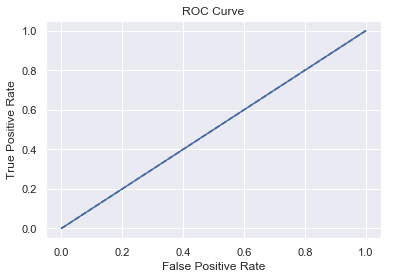

AUC: 0.5000738572892528
Accuracy Score: 0.4897959183673469


In [26]:
y_pred = svm_cv.predict(X_test)
roc_plot(svm_cv)
return_plot(smv_cv)
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)))

Model Score: 0.5080558539205156
Accuracy Score: 0.5080558539205156
[[473   0]
 [458   0]]
              precision    recall  f1-score   support

          -1       0.51      1.00      0.67       473
           1       0.00      0.00      0.00       458

   micro avg       0.51      0.51      0.51       931
   macro avg       0.25      0.50      0.34       931
weighted avg       0.26      0.51      0.34       931



/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


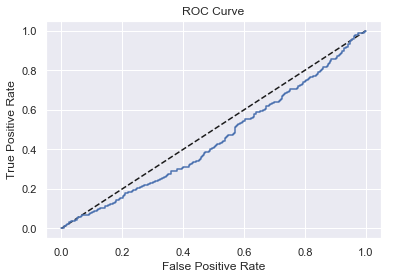

AUC: 0.4472197346676884


In [27]:
# RBF
rbf_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='rbf', gamma=5, C=0.001, probability=True))
])
rbf_svm_clf.fit(X_train, y_train)
roc_plot(rbf_svm_clf)

# ---------

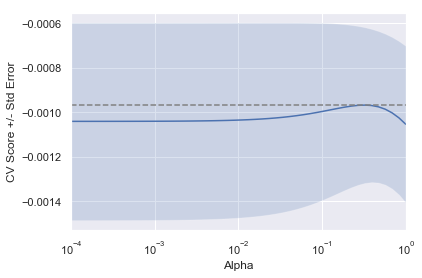

In [28]:
# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X, y, cv=10)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
ridge_plot(ridge_scores, ridge_scores_std)


# SVM

In [29]:
steps = [
    ('scaler', StandardScaler()),
    ('svc', SVC())
]
pipeline = Pipeline(steps)
params = {
    'svc__C': np.arange(1,20),
    'svc__kernel': ['linear', 'rbf', 'poly']
}
svc_cv = GridSearchCV(pipeline, params, cv=10, n_jobs=-1)
svc_cv.fit(X_train, y_train)
print("Tuned SVC Parameters: {}".format(svc_cv.best_params_))
print("Best score is {}".format(svc_cv.best_score_))

Tuned SVC Parameters: {'svc__C': 1, 'svc__kernel': 'rbf'}
Best score is 0.49946294307196565


In [30]:
bag_svm_clf = BaggingClassifier(
    svc_cv,
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1
)
bag_svm_clf.fit(X_train, y_train)
y_pred = bag_svm_clf.predict(X_test)
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)))

NameError: name 'svc' is not defined

In [31]:
svc = SVC(
    C=svc_cv.best_params_['svc__C'],
    kernel=svc_cv.best_params_['svc__kernel']
)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)))


Accuracy Score: 0.5080558539205156


/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [32]:
svc_cv.fit(X_train, y_train)
y_pred = svc_cv.predict(X_test)
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)))


Accuracy Score: 0.5102040816326531


In [ ]:
pickle.dump(open('bag_svm_clf.pickle', 'wb'))

# Neighbors

Tuned KNN Parameters: {'knn__leaf_size': 1, 'knn__n_neighbors': 8}
Best score is 0.5195130683852488
Model Score: 0.5359828141783028
Accuracy Score: 0.5359828141783028
[[279 194]
 [238 220]]
              precision    recall  f1-score   support

          -1       0.54      0.59      0.56       473
           1       0.53      0.48      0.50       458

   micro avg       0.54      0.54      0.54       931
   macro avg       0.54      0.54      0.53       931
weighted avg       0.54      0.54      0.53       931



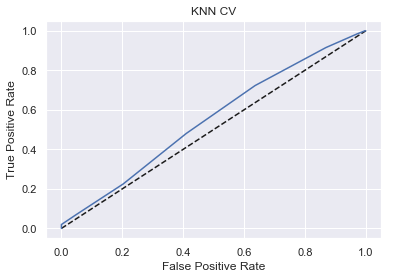

AUC: 0.5501514074429683


In [65]:
#hyper
steps = [('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())]
param_dist = {
    'knn__n_neighbors': np.arange(1,10),
    'knn__leaf_size' :np.arange(1,5),
    #'knn__weights': ['uniform', 'distance'],
    #'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    #'knn__n_jobs': [-1]
}
pipeline = Pipeline(steps)
knn_cv = GridSearchCV(pipeline, param_dist, cv=5, n_jobs=-1)
knn_cv.fit(X_train, y_train)
print("Tuned KNN Parameters: {}".format(knn_cv.best_params_))
print("Best score is {}".format(knn_cv.best_score_))
roc_plot(knn_cv, auc_cv=False, title='KNN CV')

Return: 0.4478911732093951%


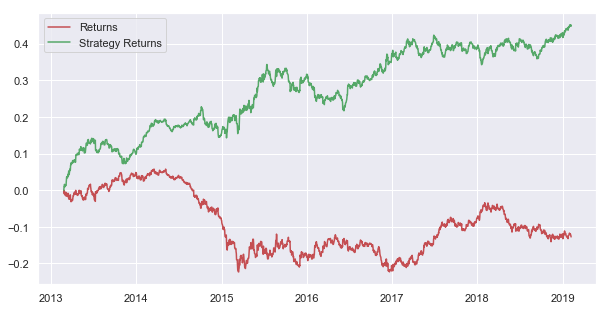

In [66]:
return_plot(knn_cv)

Model Score: 0.523093447905478
Accuracy Score: 0.523093447905478
[[429  44]
 [400  58]]
              precision    recall  f1-score   support

          -1       0.52      0.91      0.66       473
           1       0.57      0.13      0.21       458

   micro avg       0.52      0.52      0.52       931
   macro avg       0.54      0.52      0.43       931
weighted avg       0.54      0.52      0.44       931



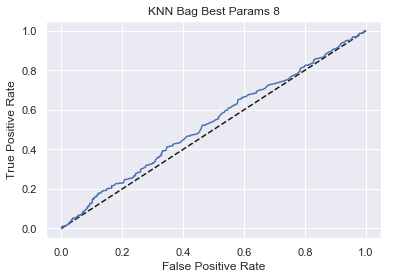

AUC: 0.5324141178208407


In [62]:
knn_bag_params = BaggingClassifier(
    KNeighborsClassifier(n_neighbors=knn_cv.best_params_['knn__n_neighbors']),
    #knn_cv,
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1
)
knn_bag_params.fit(X_train, y_train)
roc_plot(knn_bag_params, title='KNN Bag Best Params ' + str(knn_cv.best_params_['knn__n_neighbors']))

Return: 0.2597918472933285%


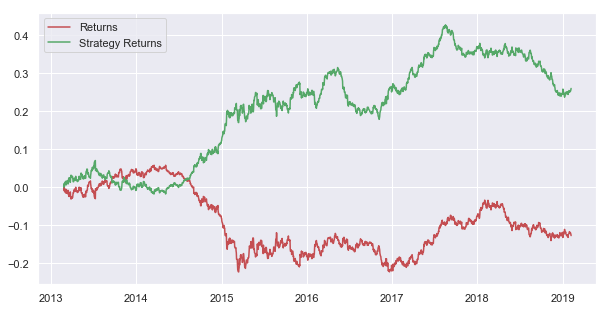

0.49516648764769067
              precision    recall  f1-score   support

          -1       0.50      0.53      0.51       471
           1       0.49      0.46      0.47       460

   micro avg       0.50      0.50      0.50       931
   macro avg       0.49      0.49      0.49       931
weighted avg       0.49      0.50      0.49       931



In [63]:
return_plot(knn_bag_params)
y_pred = knn_bag_params.predict(X_final)
print(accuracy_score(y_final, y_pred))
print(classification_report(y_final, y_pred))

In [71]:
pickle.dump(knn_cv, open('knn_final.pickle', 'wb'))

In [72]:
model = pickle.load(open('knn_final.pickle', 'rb'))
y_pred = model.predict(X_final)
print(accuracy_score(y_final, y_pred))
print(classification_report(y_final, y_pred))

0.746119733924612
              precision    recall  f1-score   support

          -1       0.74      0.77      0.75       918
           1       0.75      0.72      0.74       886

   micro avg       0.75      0.75      0.75      1804
   macro avg       0.75      0.75      0.75      1804
weighted avg       0.75      0.75      0.75      1804



# ----

# Random Forest

Model Score: 0.5026852846401718
Accuracy Score: 0.5026852846401718
[[159 314]
 [149 309]]
              precision    recall  f1-score   support

          -1       0.52      0.34      0.41       473
           1       0.50      0.67      0.57       458

   micro avg       0.50      0.50      0.50       931
   macro avg       0.51      0.51      0.49       931
weighted avg       0.51      0.50      0.49       931



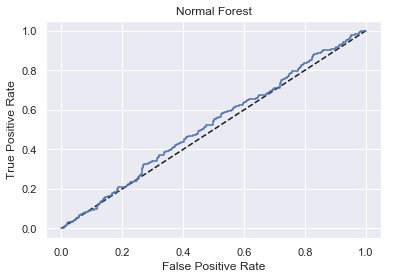

AUC: 0.5236020199968611
AUC scores computed using 5-fold cross-validation: 0.5179111171874139
Return: 0.01185292750116651%


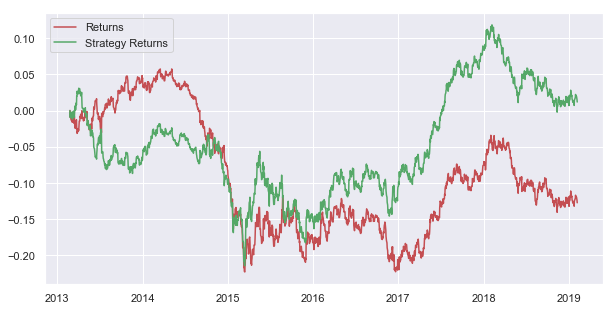

In [61]:
rnd_clf = RandomForestClassifier(
    n_estimators=1000, 
    max_leaf_nodes=100, 
    n_jobs=-1
)
steps = [
    ('scaler', StandardScaler()),
    ('rnd_clf', rnd_clf)
]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)
roc_plot(pipeline, auc_cv=False, title='Normal Forest')
return_plot(pipeline)

Model Score: 0.5166487647690655
Accuracy Score: 0.5166487647690655
[[236 237]
 [213 245]]
              precision    recall  f1-score   support

          -1       0.53      0.50      0.51       473
           1       0.51      0.53      0.52       458

   micro avg       0.52      0.52      0.52       931
   macro avg       0.52      0.52      0.52       931
weighted avg       0.52      0.52      0.52       931



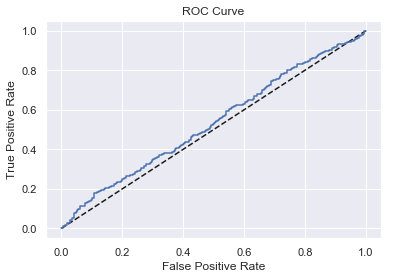

AUC: 0.5336789238992956


In [40]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)\
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

forest_cv = RandomizedSearchCV(RandomForestClassifier(), random_grid, cv=3, n_jobs=-1)
forest_cv.fit(X_train, y_train)
roc_plot(forest_cv)

In [41]:
print(forest_cv.best_params_)
print(forest_cv.best_score_)

{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': True}
0.5012531328320802


In [43]:
pickle.dump(rnd_clf, open('rnd_clf.pickle', 'wb'))

# Tree

In [60]:
#test scaler
steps = [('scaler', StandardScaler()),
        ('tree', DecisionTreeClassifier())]
        
pipeline = Pipeline(steps)
tree_scaled = pipeline.fit(X_train, y_train)
tree_unscaled = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy with Scaling: {}'.format(tree_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(tree_unscaled.score(X_test, y_test)))

Accuracy with Scaling: 0.4940923737916219
Accuracy without Scaling: 0.48442534908700324


In [89]:
#hyper
steps = [('scaler', StandardScaler()),
        ('tree', DecisionTreeClassifier())]
param_dist = {'tree__max_depth': np.linspace(1, 50, 50, endpoint=True),
              'tree__max_features': list(range(1,X.shape[1])),
              'tree__min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True),
              'tree__criterion': ['gini', 'entropy']}
pipeline = Pipeline(steps)
tree_cv = GridSearchCV(pipeline, param_dist, cv=5)
tree_cv.fit(X, y)
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

KeyboardInterrupt: 

In [59]:
tree = DecisionTreeClassifier(max_depth=tree_cv.best_params_['tree__max_depth'],
                              max_features=tree_cv.best_params_['tree__max_features'],
                              min_samples_leaf=tree_cv.best_params_['tree__min_samples_leaf'],
                              criterion=tree_cv.best_params_['tree__criterion'])
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
roc_plot(tree)

NameError: name 'tree_cv' is not defined

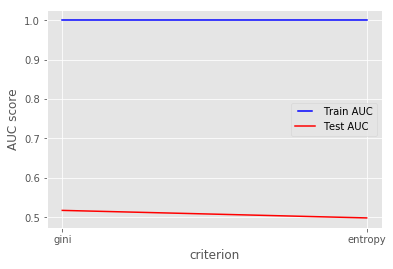

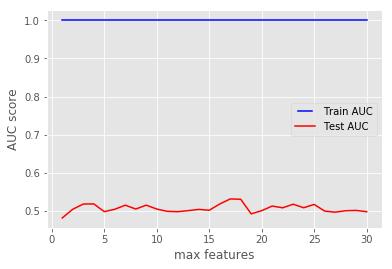

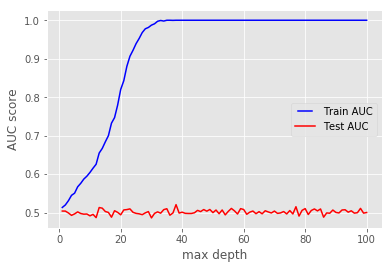

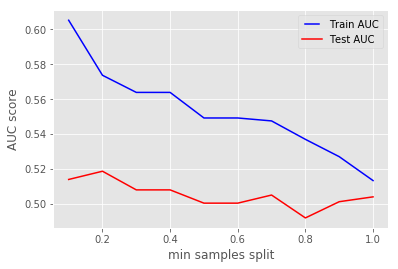

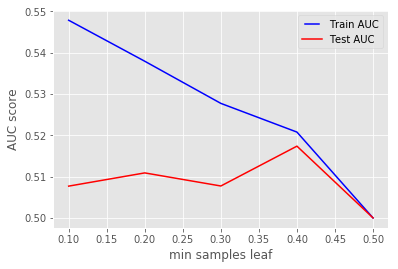

In [21]:
#criterion
criterions = ['gini', 'entropy']
train_results = []
test_results = []
for criterion in criterions:
   dt = DecisionTreeClassifier(criterion=criterion)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
line1, = plt.plot(criterions, train_results, 'b', label='Train AUC')
line2, = plt.plot(criterions, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('criterion')
plt.show()

#max features
max_features = list(range(1,X.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   dt = DecisionTreeClassifier(max_features=max_feature)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

#max depths
max_depths = np.linspace(1, 100, 100, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max depth')
plt.show()

#min samples split
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

#min samples leaf
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()